In [47]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
PROJECT_ID = ""

In [49]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

In [8]:
query_base_cohort = """
-- ================================================================
-- MIMIC-IV v3.1 Blood Transfusion Base Cohort (Corrected)
-- ================================================================
WITH transfusions AS (
  SELECT
    ie.subject_id,
    ie.hadm_id,
    ie.stay_id,
    ie.starttime AS transfusion_time,
    icu.los,
    icu.first_careunit,
    ie.caregiver_id
  FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
  INNER JOIN `physionet-data.mimiciv_3_1_icu.icustays` icu
    ON ie.stay_id = icu.stay_id
  WHERE ie.itemid IN (225168, 226368, 227070, 221013)  -- RBC transfusion item IDs
    AND ie.statusdescription != 'Rewritten'
),

base_cohort AS (
  SELECT DISTINCT
    t.subject_id,
    t.hadm_id,
    t.stay_id,
    t.los,
    p.gender,
    p.anchor_age AS age,
    adm.race,                         -- ✅ race now from admissions
    p.dod,
    h.valuenum AS pre_transfusion_hgb,
    CASE
      WHEN h.valuenum >= 8 THEN 'Early'
      WHEN h.valuenum < 8 THEN 'Late'
    END AS transfusion_group
  FROM transfusions t
  INNER JOIN `physionet-data.mimiciv_3_1_hosp.patients` p
    ON t.subject_id = p.subject_id
  INNER JOIN `physionet-data.mimiciv_3_1_hosp.admissions` adm
    ON t.hadm_id = adm.hadm_id        -- ✅ join for race and admission details
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.labevents` h
    ON t.subject_id = h.subject_id
    AND t.hadm_id = h.hadm_id
    AND h.itemid IN (50811, 51222, 51640)
    AND h.charttime < t.transfusion_time
    AND h.charttime >= TIMESTAMP_SUB(t.transfusion_time, INTERVAL 24 HOUR)
    AND h.valuenum BETWEEN 2 AND 25
  WHERE h.valuenum IS NOT NULL
)
SELECT * FROM base_cohort
LIMIT 100
"""

In [9]:
df_base = client.query(query_base_cohort).to_dataframe()
df_base.head()

,subject_id,hadm_id,stay_id,los,gender,age,race,dod,pre_transfusion_hgb,transfusion_group
0,10782077,26381429,35120997,6.163241,F,61,WHITE,NaT,8.0,Early
1,11335681,24866944,32440203,0.887731,M,73,WHITE,2113-04-30,9.3,Early
2,11471705,29497940,34076052,5.341146,M,41,WHITE,NaT,9.7,Early
3,13976104,24855016,37726131,2.245498,M,69,WHITE,NaT,7.5,Late
4,14890843,28005335,34332361,2.232720,F,79,WHITE,NaT,11.8,Early


In [12]:
query_summary = """
-- ================================================================
-- Overall Summary by Transfusion Group (Hgb < 8 vs ≥ 8)
-- ================================================================
WITH transfusions AS (
  SELECT
    ie.subject_id,
    ie.hadm_id,
    ie.stay_id,
    ie.starttime AS transfusion_time,
    icu.los,
    icu.first_careunit
  FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
  INNER JOIN `physionet-data.mimiciv_3_1_icu.icustays` icu
    ON ie.stay_id = icu.stay_id
  WHERE ie.itemid IN (225168, 226368, 227070, 221013)
    AND ie.statusdescription != 'Rewritten'
),

base_cohort AS (
  SELECT DISTINCT
    t.subject_id,
    t.hadm_id,
    t.stay_id,
    icu.los,
    p.gender,
    p.anchor_age AS age,
    adm.race,
    p.dod,
    h.valuenum AS pre_transfusion_hgb,
    CASE
      WHEN h.valuenum >= 8 THEN 'Early'
      WHEN h.valuenum < 8 THEN 'Late'
    END AS transfusion_group
  FROM transfusions t
  INNER JOIN `physionet-data.mimiciv_3_1_icu.icustays` icu
    ON t.stay_id = icu.stay_id
  INNER JOIN `physionet-data.mimiciv_3_1_hosp.patients` p
    ON t.subject_id = p.subject_id
  INNER JOIN `physionet-data.mimiciv_3_1_hosp.admissions` adm
    ON t.hadm_id = adm.hadm_id
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.labevents` h
    ON t.subject_id = h.subject_id
    AND t.hadm_id = h.hadm_id
    AND h.itemid IN (50811, 51222, 51640)
    AND h.charttime < t.transfusion_time
    AND h.charttime >= TIMESTAMP_SUB(t.transfusion_time, INTERVAL 24 HOUR)
    AND h.valuenum BETWEEN 2 AND 25
  WHERE h.valuenum IS NOT NULL
)

SELECT
  transfusion_group,
  COUNT(DISTINCT subject_id) AS n_patients,
  ROUND(AVG(pre_transfusion_hgb), 2) AS avg_hgb,
  ROUND(APPROX_QUANTILES(pre_transfusion_hgb, 2)[OFFSET(1)], 2) AS median_hgb,
  ROUND(MIN(pre_transfusion_hgb), 2) AS min_hgb,
  ROUND(MAX(pre_transfusion_hgb), 2) AS max_hgb,
  ROUND(STDDEV(pre_transfusion_hgb), 2) AS std_hgb,
  ROUND(AVG(los), 1) AS avg_icu_los_days,
  ROUND(COUNT(DISTINCT CASE WHEN dod IS NOT NULL THEN subject_id END) * 100.0 /
        COUNT(DISTINCT subject_id), 1) AS mortality_pct
FROM base_cohort
GROUP BY transfusion_group
ORDER BY transfusion_group
"""

In [13]:
df_summary = client.query(query_summary).to_dataframe()
df_summary

,transfusion_group,n_patients,avg_hgb,median_hgb,min_hgb,max_hgb,std_hgb,avg_icu_los_days,mortality_pct
0,Early,12349,9.67,9.3,8.0,19.6,1.42,8.2,41.3
1,Late,12113,7.03,7.1,2.0,7.9,0.68,9.8,47.8


In [14]:
query_gender = """
-- ================================================================
-- Gender Distribution by Transfusion Group
-- ================================================================
WITH base_cohort AS (
  SELECT DISTINCT
    ie.subject_id,
    p.gender,
    CASE
      WHEN h.valuenum >= 8 THEN 'Early'
      WHEN h.valuenum < 8 THEN 'Late'
    END AS transfusion_group
  FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
  INNER JOIN `physionet-data.mimiciv_3_1_hosp.patients` p
    ON ie.subject_id = p.subject_id
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.labevents` h
    ON ie.subject_id = h.subject_id
    AND ie.hadm_id = h.hadm_id
    AND h.itemid IN (50811, 51222, 51640)
    AND h.charttime < ie.starttime
    AND h.charttime >= TIMESTAMP_SUB(ie.starttime, INTERVAL 24 HOUR)
    AND h.valuenum BETWEEN 2 AND 25
  WHERE ie.itemid IN (225168, 226368, 227070, 221013)
    AND h.valuenum IS NOT NULL
)
SELECT
  transfusion_group,
  gender,
  COUNT(DISTINCT subject_id) AS n_patients,
  ROUND(COUNT(DISTINCT subject_id) * 100.0 /
        SUM(COUNT(DISTINCT subject_id)) OVER (PARTITION BY transfusion_group), 1) AS pct_within_group
FROM base_cohort
GROUP BY transfusion_group, gender
ORDER BY transfusion_group, gender
"""

In [15]:
df_gender = client.query(query_gender).to_dataframe()
df_gender

,transfusion_group,gender,n_patients,pct_within_group
0,Early,F,5464,44.2
1,Early,M,6885,55.8
2,Late,F,5759,47.5
3,Late,M,6354,52.5


In [16]:
query_age = """
-- ================================================================
-- Age Group Distribution by Transfusion Group
-- ================================================================
WITH base_cohort AS (
  SELECT DISTINCT
    ie.subject_id,
    p.anchor_age AS age,
    CASE
      WHEN h.valuenum >= 8 THEN 'Early'
      WHEN h.valuenum < 8 THEN 'Late'
    END AS transfusion_group
  FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
  INNER JOIN `physionet-data.mimiciv_3_1_hosp.patients` p
    ON ie.subject_id = p.subject_id
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.labevents` h
    ON ie.subject_id = h.subject_id
    AND ie.hadm_id = h.hadm_id
    AND h.itemid IN (50811, 51222, 51640)
    AND h.charttime < ie.starttime
    AND h.charttime >= TIMESTAMP_SUB(ie.starttime, INTERVAL 24 HOUR)
    AND h.valuenum BETWEEN 2 AND 25
  WHERE ie.itemid IN (225168, 226368, 227070, 221013)
    AND h.valuenum IS NOT NULL
)
SELECT
  transfusion_group,
  CASE
    WHEN age < 40 THEN '18–39'
    WHEN age BETWEEN 40 AND 59 THEN '40–59'
    WHEN age BETWEEN 60 AND 74 THEN '60–74'
    ELSE '75+'
  END AS age_group,
  COUNT(DISTINCT subject_id) AS n_patients,
  ROUND(COUNT(DISTINCT subject_id) * 100.0 /
        SUM(COUNT(DISTINCT subject_id)) OVER (PARTITION BY transfusion_group), 1) AS pct_within_group
FROM base_cohort
GROUP BY transfusion_group, age_group
ORDER BY transfusion_group, age_group
"""

In [17]:
df_age = client.query(query_age).to_dataframe()
df_age

,transfusion_group,age_group,n_patients,pct_within_group
0,Early,18–39,897,7.3
1,Early,40–59,3021,24.5
2,Early,60–74,4567,37.0
3,Early,75+,3864,31.3
4,Late,18–39,960,7.9
5,Late,40–59,3077,25.4
6,Late,60–74,4448,36.7
7,Late,75+,3628,30.0


In [18]:
query_race = """
-- ================================================================
-- Race / Ethnicity Distribution by Transfusion Group
-- ================================================================
WITH base_cohort AS (
  SELECT DISTINCT
    ie.subject_id,
    adm.race,
    CASE
      WHEN h.valuenum >= 8 THEN 'Early'
      WHEN h.valuenum < 8 THEN 'Late'
    END AS transfusion_group
  FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
  INNER JOIN `physionet-data.mimiciv_3_1_hosp.admissions` adm
    ON ie.hadm_id = adm.hadm_id
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.labevents` h
    ON ie.subject_id = h.subject_id
    AND ie.hadm_id = h.hadm_id
    AND h.itemid IN (50811, 51222, 51640)
    AND h.charttime < ie.starttime
    AND h.charttime >= TIMESTAMP_SUB(ie.starttime, INTERVAL 24 HOUR)
    AND h.valuenum BETWEEN 2 AND 25
  WHERE ie.itemid IN (225168, 226368, 227070, 221013)
    AND h.valuenum IS NOT NULL
)
SELECT
  transfusion_group,
  race,
  COUNT(DISTINCT subject_id) AS n_patients,
  ROUND(COUNT(DISTINCT subject_id) * 100.0 /
        SUM(COUNT(DISTINCT subject_id)) OVER (PARTITION BY transfusion_group), 1) AS pct_within_group
FROM base_cohort
GROUP BY transfusion_group, race
ORDER BY transfusion_group, n_patients DESC
"""

In [19]:
df_race = client.query(query_race).to_dataframe()
df_race

,transfusion_group,race,n_patients,pct_within_group
0,Early,WHITE,8063,65.0
1,Early,UNKNOWN,1295,10.4
2,Early,BLACK/AFRICAN AMERICAN,803,6.5
3,Early,OTHER,408,3.3
4,Early,WHITE - OTHER EUROPEAN,239,1.9
...,...,...,...,...
61,Late,ASIAN - KOREAN,11,0.1
62,Late,HISPANIC/LATINO - MEXICAN,11,0.1
63,Late,HISPANIC/LATINO - CENTRAL AMERICAN,10,0.1
64,Late,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,9,0.1


In [20]:
query_hgb_bands = """
-- ================================================================
-- Haemoglobin Band Distribution by Transfusion Group
-- ================================================================
WITH base_cohort AS (
  SELECT DISTINCT
    ie.subject_id,
    h.valuenum AS pre_transfusion_hgb,
    CASE
      WHEN h.valuenum >= 8 THEN 'Early'
      WHEN h.valuenum < 8 THEN 'Late'
    END AS transfusion_group
  FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.labevents` h
    ON ie.subject_id = h.subject_id
    AND ie.hadm_id = h.hadm_id
    AND h.itemid IN (50811, 51222, 51640)
    AND h.charttime < ie.starttime
    AND h.charttime >= TIMESTAMP_SUB(ie.starttime, INTERVAL 24 HOUR)
    AND h.valuenum BETWEEN 2 AND 25
  WHERE ie.itemid IN (225168, 226368, 227070, 221013)
    AND h.valuenum IS NOT NULL
)
SELECT
  transfusion_group,
  CASE
    WHEN pre_transfusion_hgb < 6 THEN '<6'
    WHEN pre_transfusion_hgb BETWEEN 6 AND 6.9 THEN '6–6.9'
    WHEN pre_transfusion_hgb BETWEEN 7 AND 7.9 THEN '7–7.9'
    WHEN pre_transfusion_hgb BETWEEN 8 AND 8.9 THEN '8–8.9'
    WHEN pre_transfusion_hgb BETWEEN 9 AND 9.9 THEN '9–9.9'
    ELSE '≥10'
  END AS hgb_band,
  COUNT(*) AS n_records,
  ROUND(COUNT(*) * 100.0 /
        SUM(COUNT(*)) OVER (PARTITION BY transfusion_group), 1) AS pct_within_group
FROM base_cohort
GROUP BY transfusion_group, hgb_band
ORDER BY transfusion_group, hgb_band
"""

In [21]:
df_hgb = client.query(query_hgb_bands).to_dataframe()
df_hgb

,transfusion_group,hgb_band,n_records,pct_within_group
0,Early,8–8.9,21834,37.5
1,Early,9–9.9,16154,27.7
2,Early,≥10,20268,34.8
3,Late,6–6.9,13311,33.2
4,Late,7–7.9,24162,60.2
5,Late,<6,2637,6.6


In [25]:
df_summary.to_csv("summary_results.csv", index=False)
df_gender.to_csv("gender_distribution.csv", index=False)
df_age.to_csv("age_distribution.csv", index=False)
df_race.to_csv("race_distribution.csv", index=False)
df_hgb.to_csv("hgb_band_distribution.csv", index=False)

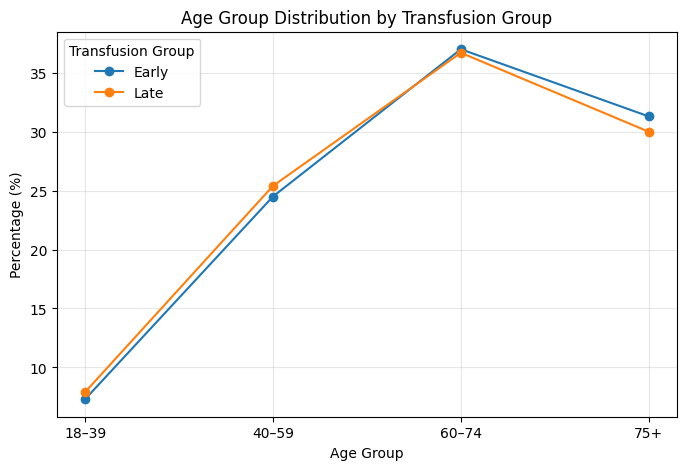

In [28]:
fig, ax = plt.subplots(figsize=(8,5))
age_order = ["18–39", "40–59", "60–74", "75+"]
for group in df_age["transfusion_group"].unique():
    subset = df_age[df_age["transfusion_group"] == group]
    subset = subset.set_index("age_group").reindex(age_order).reset_index()
    ax.plot(subset["age_group"], subset["pct_within_group"], marker='o', label=group)

ax.set_title("Age Group Distribution by Transfusion Group")
ax.set_xlabel("Age Group")
ax.set_ylabel("Percentage (%)")
ax.legend(title="Transfusion Group")
plt.grid(alpha=0.3)
plt.show()

In [56]:
query_cardiovascular_refined_fixed = """
WITH transfusions AS (
  SELECT
    ie.subject_id,
    ie.hadm_id,
    ie.stay_id,
    MIN(ie.starttime) AS first_transfusion_time
  FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
  WHERE ie.itemid IN (225168,226368,227070,221013)
    AND ie.statusdescription != 'Rewritten'
  GROUP BY subject_id, hadm_id, stay_id
),

labs AS (
  SELECT subject_id, hadm_id, charttime, valuenum AS hgb
  FROM `physionet-data.mimiciv_3_1_hosp.labevents`
  WHERE itemid IN (50811,51222,51640) AND valuenum BETWEEN 2 AND 25
),

closest_pre AS (
  SELECT l.subject_id, l.hadm_id, l.hgb, l.charttime
  FROM labs l
  JOIN transfusions t
    ON l.subject_id = t.subject_id AND l.hadm_id = t.hadm_id
  WHERE l.charttime < t.first_transfusion_time
    AND l.charttime >= TIMESTAMP_SUB(t.first_transfusion_time, INTERVAL 24 HOUR)
  QUALIFY ROW_NUMBER() OVER (PARTITION BY t.subject_id, t.hadm_id ORDER BY t.first_transfusion_time - l.charttime ASC)=1
),

earliest_post AS (
  SELECT l.subject_id, l.hadm_id, l.hgb, l.charttime
  FROM labs l
  JOIN transfusions t
    ON l.subject_id = t.subject_id AND l.hadm_id = t.hadm_id
  WHERE l.charttime > t.first_transfusion_time
    AND l.charttime <= TIMESTAMP_ADD(t.first_transfusion_time, INTERVAL 48 HOUR)
    AND l.charttime >= TIMESTAMP_ADD(t.first_transfusion_time, INTERVAL 6 HOUR)
  QUALIFY ROW_NUMBER() OVER (PARTITION BY t.subject_id, t.hadm_id ORDER BY l.charttime ASC)=1
),

cv_primary AS (
  SELECT DISTINCT d.hadm_id
  FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` d
  JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` dd
    ON d.icd_code = dd.icd_code
  WHERE d.seq_num=1
    AND (
      LOWER(dd.long_title) LIKE '%cardio%' OR
      LOWER(dd.long_title) LIKE '%coronary%' OR
      LOWER(dd.long_title) LIKE '%heart%' OR
      LOWER(dd.long_title) LIKE '%valve%' OR
      LOWER(dd.long_title) LIKE '%myocardial%'
    )
),

merged AS (
  SELECT
    t.subject_id,
    t.hadm_id,
    t.stay_id,
    p.gender,
    p.anchor_age AS age,
    a.race,
    a.admission_type,
    a.insurance,
    a.hospital_expire_flag AS death,
    icu.first_careunit,
    pre.hgb AS pre_hgb,
    post.hgb AS post_hgb,
    ROUND(post.hgb - pre.hgb,2) AS delta_hgb,
    ROUND(TIMESTAMP_DIFF(t.first_transfusion_time, icu.intime, HOUR),1) AS hours_to_first_transfusion,
    ROUND(icu.los,1) AS icu_los_days,
    CASE WHEN pre.hgb >= 8 THEN 'Early' ELSE 'Late' END AS transfusion_group
  FROM transfusions t
  JOIN `physionet-data.mimiciv_3_1_hosp.patients` p
    ON t.subject_id = p.subject_id
  JOIN `physionet-data.mimiciv_3_1_hosp.admissions` a
    ON t.hadm_id = a.hadm_id
  JOIN `physionet-data.mimiciv_3_1_icu.icustays` icu
    ON t.stay_id = icu.stay_id
  JOIN closest_pre pre
    ON t.subject_id = pre.subject_id AND t.hadm_id = pre.hadm_id
  LEFT JOIN earliest_post post
    ON t.subject_id = post.subject_id AND t.hadm_id = post.hadm_id
  JOIN cv_primary cv
    ON t.hadm_id = cv.hadm_id
),

summary AS (
  SELECT
    transfusion_group,
    COUNT(DISTINCT subject_id) AS n_patients,
    ROUND(AVG(pre_hgb),2) AS avg_pre_hgb,
    ROUND(AVG(post_hgb),2) AS avg_post_hgb,
    ROUND(AVG(delta_hgb),2) AS avg_delta_hgb,
    ROUND(AVG(hours_to_first_transfusion),1) AS avg_hours_to_first_transfusion,
    ROUND(AVG(icu_los_days),1) AS avg_icu_los_days,
    ROUND(SUM(CASE WHEN death=1 THEN 1 ELSE 0 END)*100.0/COUNT(DISTINCT subject_id),2) AS hospital_mortality_pct,
    ROUND(SUM(CASE WHEN LOWER(admission_type) LIKE '%elect%' THEN 1 ELSE 0 END)*100.0/COUNT(*),1) AS pct_elective,
    ROUND(SUM(CASE WHEN LOWER(admission_type) LIKE '%emerg%' THEN 1 ELSE 0 END)*100.0/COUNT(*),1) AS pct_emergency
  FROM merged
  GROUP BY transfusion_group
)
SELECT * FROM summary ORDER BY transfusion_group;
"""

df_cv_refined = client.query(query_cardiovascular_refined_fixed).to_dataframe()
display(df_cv_refined)

,transfusion_group,n_patients,avg_pre_hgb,avg_post_hgb,avg_delta_hgb,avg_hours_to_first_transfusion,avg_icu_los_days,hospital_mortality_pct,pct_elective,pct_emergency
0,Early,2460,9.43,9.76,0.34,18.1,5.0,5.24,16.4,0.0
1,Late,1409,7.14,8.89,1.75,32.3,5.5,12.14,11.0,0.0


In [64]:
query_cardiovascular_demo_full = """
WITH transfusions AS (
  SELECT
    ie.subject_id,
    ie.hadm_id,
    ie.stay_id,
    MIN(ie.starttime) AS first_transfusion_time
  FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
  WHERE ie.itemid IN (225168,226368,227070,221013)
    AND ie.statusdescription != 'Rewritten'
  GROUP BY subject_id, hadm_id, stay_id
),

labs AS (
  SELECT subject_id, hadm_id, charttime, valuenum AS hgb
  FROM `physionet-data.mimiciv_3_1_hosp.labevents`
  WHERE itemid IN (50811,51222,51640)
    AND valuenum BETWEEN 2 AND 25
),

closest_pre AS (
  SELECT l.subject_id, l.hadm_id, l.hgb
  FROM labs l
  JOIN transfusions t
    ON l.subject_id = t.subject_id AND l.hadm_id = t.hadm_id
  WHERE l.charttime < t.first_transfusion_time
    AND l.charttime >= TIMESTAMP_SUB(t.first_transfusion_time, INTERVAL 24 HOUR)
  QUALIFY ROW_NUMBER() OVER (PARTITION BY t.subject_id, t.hadm_id ORDER BY t.first_transfusion_time - l.charttime ASC) = 1
),

cv_primary AS (
  SELECT DISTINCT d.hadm_id
  FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` d
  JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` dd
    ON d.icd_code = dd.icd_code
  WHERE d.seq_num = 1
    AND (
      LOWER(dd.long_title) LIKE '%cardio%' OR
      LOWER(dd.long_title) LIKE '%coronary%' OR
      LOWER(dd.long_title) LIKE '%heart%' OR
      LOWER(dd.long_title) LIKE '%valve%' OR
      LOWER(dd.long_title) LIKE '%myocardial%'
    )
),

merged AS (
  SELECT
    t.subject_id,
    t.hadm_id,
    p.gender,
    p.anchor_age AS age,
    a.race,
    a.insurance,
    a.admission_type,
    a.hospital_expire_flag AS death,
    pre.hgb AS pre_hgb,
    CASE WHEN pre.hgb >= 8 THEN 'Early' ELSE 'Late' END AS transfusion_group
  FROM transfusions t
  JOIN `physionet-data.mimiciv_3_1_hosp.patients` p
    ON t.subject_id = p.subject_id
  JOIN `physionet-data.mimiciv_3_1_hosp.admissions` a
    ON t.hadm_id = a.hadm_id
  JOIN closest_pre pre
    ON t.subject_id = pre.subject_id AND t.hadm_id = pre.hadm_id
  JOIN cv_primary cv
    ON t.hadm_id = cv.hadm_id
),

age_groups AS (
  SELECT *,
    CASE
      WHEN age < 40 THEN '<40'
      WHEN age BETWEEN 40 AND 59 THEN '40–59'
      WHEN age BETWEEN 60 AND 79 THEN '60–79'
      ELSE '80+'
    END AS age_group
  FROM merged
),

-- 1️⃣ Summary
summary AS (
  SELECT
    'summary' AS table_type,
    transfusion_group,
    CAST(NULL AS STRING) AS category,
    CAST(COUNT(DISTINCT subject_id) AS STRING) AS n_patients,
    ROUND(AVG(pre_hgb),2) AS avg_pre_hgb,
    ROUND(AVG(age),1) AS avg_age,
    ROUND(SUM(CASE WHEN gender='M' THEN 1 ELSE 0 END)*100.0/COUNT(*),1) AS pct_male,
    ROUND(SUM(CASE WHEN death=1 THEN 1 ELSE 0 END)*100.0/COUNT(*),2) AS mortality_pct
  FROM age_groups
  GROUP BY transfusion_group
),

-- 2️⃣ Gender
by_gender AS (
  SELECT
    'by_gender' AS table_type,
    transfusion_group,
    gender AS category,
    CAST(COUNT(DISTINCT subject_id) AS STRING) AS n_patients,
    NULL AS avg_pre_hgb,
    NULL AS avg_age,
    NULL AS pct_male,
    NULL AS mortality_pct
  FROM age_groups
  GROUP BY transfusion_group, gender
),

-- 3️⃣ Age
by_age AS (
  SELECT
    'by_age' AS table_type,
    transfusion_group,
    age_group AS category,
    CAST(COUNT(DISTINCT subject_id) AS STRING) AS n_patients,
    NULL AS avg_pre_hgb,
    NULL AS avg_age,
    NULL AS pct_male,
    NULL AS mortality_pct
  FROM age_groups
  GROUP BY transfusion_group, age_group
),

-- 4️⃣ Race
by_race AS (
  SELECT
    'by_race' AS table_type,
    transfusion_group,
    race AS category,
    CAST(COUNT(DISTINCT subject_id) AS STRING) AS n_patients,
    NULL AS avg_pre_hgb,
    NULL AS avg_age,
    NULL AS pct_male,
    NULL AS mortality_pct
  FROM age_groups
  GROUP BY transfusion_group, race
),

-- 5️⃣ Insurance
by_insurance AS (
  SELECT
    'by_insurance' AS table_type,
    transfusion_group,
    insurance AS category,
    CAST(COUNT(DISTINCT subject_id) AS STRING) AS n_patients,
    NULL AS avg_pre_hgb,
    NULL AS avg_age,
    NULL AS pct_male,
    NULL AS mortality_pct
  FROM age_groups
  GROUP BY transfusion_group, insurance
),

-- 6️⃣ Admission Type
by_admission AS (
  SELECT
    'by_admission' AS table_type,
    transfusion_group,
    admission_type AS category,
    CAST(COUNT(DISTINCT subject_id) AS STRING) AS n_patients,
    NULL AS avg_pre_hgb,
    NULL AS avg_age,
    NULL AS pct_male,
    NULL AS mortality_pct
  FROM age_groups
  GROUP BY transfusion_group, admission_type
)

-- Combine all tables (aligned types)
SELECT * FROM summary
UNION ALL SELECT * FROM by_gender
UNION ALL SELECT * FROM by_age
UNION ALL SELECT * FROM by_race
UNION ALL SELECT * FROM by_insurance
UNION ALL SELECT * FROM by_admission
ORDER BY table_type, transfusion_group;
"""

df_demo_full = client.query(query_cardiovascular_demo_full).to_dataframe()
display(df_demo_full)

,table_type,transfusion_group,category,n_patients,avg_pre_hgb,avg_age,pct_male,mortality_pct
0,by_admission,Early,ELECTIVE,409,NaN,NaN,NaN,NaN
1,by_admission,Early,SURGICAL SAME DAY ADMISSION,681,NaN,NaN,NaN,NaN
2,by_admission,Early,URGENT,687,NaN,NaN,NaN,NaN
3,by_admission,Early,OBSERVATION ADMIT,182,NaN,NaN,NaN,NaN
4,by_admission,Early,EW EMER.,366,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
90,by_race,Late,HISPANIC/LATINO - HONDURAN,1,NaN,NaN,NaN,NaN
91,by_race,Late,WHITE - EASTERN EUROPEAN,2,NaN,NaN,NaN,NaN
92,by_race,Late,ASIAN - SOUTH EAST ASIAN,2,NaN,NaN,NaN,NaN
93,summary,Early,None,2457,9.43,70.8,56.7,5.03


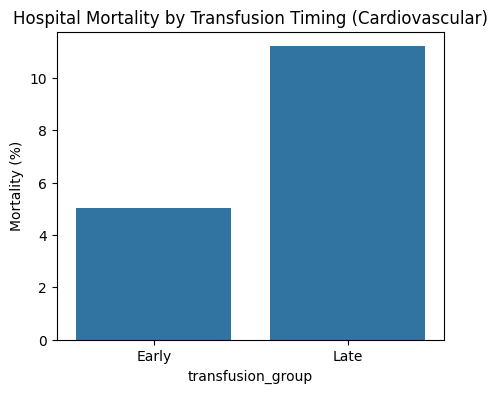

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter by sections
summary = df_demo_full[df_demo_full['table_type']=='summary']
by_age = df_demo_full[df_demo_full['table_type']=='by_age']
by_gender = df_demo_full[df_demo_full['table_type']=='by_gender']
by_race = df_demo_full[df_demo_full['table_type']=='by_race']
by_insurance = df_demo_full[df_demo_full['table_type']=='by_insurance']
by_admission = df_demo_full[df_demo_full['table_type']=='by_admission']

# Summary: mortality comparison
plt.figure(figsize=(5,4))
sns.barplot(x='transfusion_group', y='mortality_pct', data=summary)
plt.title('Hospital Mortality by Transfusion Timing (Cardiovascular)')
plt.ylabel('Mortality (%)')
plt.show()


In [66]:
import pandas as pd

# Create a folder path to save your results (optional)
output_dir = "/content/cardiovascular_demo_results"
!mkdir -p $output_dir

# ✅ Save each subset as a CSV
summary.to_csv(f"{output_dir}/summary.csv", index=False)
by_age.to_csv(f"{output_dir}/by_age.csv", index=False)
by_gender.to_csv(f"{output_dir}/by_gender.csv", index=False)
by_race.to_csv(f"{output_dir}/by_race.csv", index=False)
by_insurance.to_csv(f"{output_dir}/by_insurance.csv", index=False)
by_admission.to_csv(f"{output_dir}/by_admission.csv", index=False)

# ✅ Combine all into a single CSV
df_demo_full.to_csv(f"{output_dir}/demographics_full.csv", index=False)

# Display file list and preview
import os
print("Saved files:")
for f in os.listdir(output_dir):
    print("-", f)

print("\nPreview of demographics_full.csv:")
pd.read_csv(f"{output_dir}/demographics_full.csv").head(10)

Saved files:
- demographics_full.csv
- by_admission.csv
- by_age.csv
- by_race.csv
- by_insurance.csv
- by_gender.csv
- summary.csv

Preview of demographics_full.csv:


,table_type,transfusion_group,category,n_patients,avg_pre_hgb,avg_age,pct_male,mortality_pct
0,by_admission,Early,ELECTIVE,409,NaN,NaN,NaN,NaN
1,by_admission,Early,SURGICAL SAME DAY ADMISSION,681,NaN,NaN,NaN,NaN
2,by_admission,Early,URGENT,687,NaN,NaN,NaN,NaN
3,by_admission,Early,OBSERVATION ADMIT,182,NaN,NaN,NaN,NaN
4,by_admission,Early,EW EMER.,366,NaN,NaN,NaN,NaN
5,by_admission,Early,DIRECT EMER.,151,NaN,NaN,NaN,NaN
6,by_admission,Late,ELECTIVE,162,NaN,NaN,NaN,NaN
7,by_admission,Late,URGENT,396,NaN,NaN,NaN,NaN
8,by_admission,Late,OBSERVATION ADMIT,205,NaN,NaN,NaN,NaN
9,by_admission,Late,SURGICAL SAME DAY ADMISSION,287,NaN,NaN,NaN,NaN


In [68]:
query_top5_diagnoses = """
-- ================================================
-- Top 5 Primary Diagnoses Among Transfusion Patients
-- ================================================

WITH transfusions AS (
  SELECT
    ie.subject_id,
    ie.hadm_id,
    ie.stay_id,
    MIN(ie.starttime) AS first_transfusion_time
  FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
  WHERE ie.itemid IN (225168, 226368, 227070, 221013)
    AND ie.statusdescription != 'Rewritten'
  GROUP BY subject_id, hadm_id, stay_id
),

labs AS (
  SELECT
    subject_id, hadm_id, charttime, valuenum AS hgb
  FROM `physionet-data.mimiciv_3_1_hosp.labevents`
  WHERE itemid IN (50811, 51222, 51640)
    AND valuenum BETWEEN 2 AND 25
),

-- Closest pre-transfusion Hgb (within 24h)
closest_pre AS (
  SELECT l.subject_id, l.hadm_id, l.hgb
  FROM labs l
  JOIN transfusions t
    ON l.subject_id = t.subject_id AND l.hadm_id = t.hadm_id
  WHERE l.charttime < t.first_transfusion_time
    AND l.charttime >= TIMESTAMP_SUB(t.first_transfusion_time, INTERVAL 24 HOUR)
  QUALIFY ROW_NUMBER() OVER (PARTITION BY t.subject_id, t.hadm_id ORDER BY t.first_transfusion_time - l.charttime ASC) = 1
),

-- Determine transfusion group (early vs late)
grouped AS (
  SELECT
    t.subject_id,
    t.hadm_id,
    CASE
      WHEN pre.hgb >= 8 THEN 'Early'
      ELSE 'Late'
    END AS transfusion_group
  FROM transfusions t
  JOIN closest_pre pre
    ON t.subject_id = pre.subject_id AND t.hadm_id = pre.hadm_id
),

-- Link to diagnoses
diagnosis AS (
  SELECT
    d.subject_id,
    d.hadm_id,
    d.seq_num,
    d.icd_code,
    d.icd_version,
    dd.long_title AS diagnosis_name
  FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` d
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` dd
    ON d.icd_code = dd.icd_code
    AND d.icd_version = dd.icd_version
  WHERE seq_num = 1
),

merged AS (
  SELECT
    g.transfusion_group,
    d.diagnosis_name,
    g.hadm_id
  FROM grouped g
  JOIN diagnosis d
    ON g.hadm_id = d.hadm_id
  WHERE d.diagnosis_name IS NOT NULL
),

summary AS (
  SELECT
    transfusion_group,
    diagnosis_name,
    COUNT(DISTINCT hadm_id) AS n_patients,
    ROUND(COUNT(DISTINCT hadm_id) * 100.0 /
          SUM(COUNT(DISTINCT hadm_id)) OVER (PARTITION BY transfusion_group), 2) AS pct_within_group
  FROM merged
  GROUP BY transfusion_group, diagnosis_name
),

ranked AS (
  SELECT *,
         ROW_NUMBER() OVER (PARTITION BY transfusion_group ORDER BY n_patients DESC) AS rn
  FROM summary
)

SELECT
  transfusion_group,
  diagnosis_name,
  n_patients,
  pct_within_group
FROM ranked
WHERE rn <= 5
ORDER BY transfusion_group, rn;
"""

# --- Run and display ---
df_top5 = client.query(query_top5_diagnoses).to_dataframe()
display(df_top5)

,transfusion_group,diagnosis_name,n_patients,pct_within_group
0,Early,Coronary atherosclerosis of native coronary ar...,598,7.42
1,Early,Aortic valve disorders,463,5.74
2,Early,"Subendocardial infarction, initial episode of ...",261,3.24
3,Early,Non-ST elevation (NSTEMI) myocardial infarction,190,2.36
4,Early,Unspecified septicemia,167,2.07
5,Late,"Sepsis, unspecified organism",541,5.76
6,Late,Unspecified septicemia,352,3.75
7,Late,Non-ST elevation (NSTEMI) myocardial infarction,177,1.88
8,Late,Coronary atherosclerosis of native coronary ar...,173,1.84
9,Late,Atherosclerotic heart disease of native corona...,131,1.40
